In [ ]:
# Сначала загружаем библиотеки, которые нам могут понадобиться
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

Saving Pikachu (1).png to Pikachu (1) (2).png
Форма изображения после предобработки: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Распознанный объект: mortarboard с уверенностью 0.16


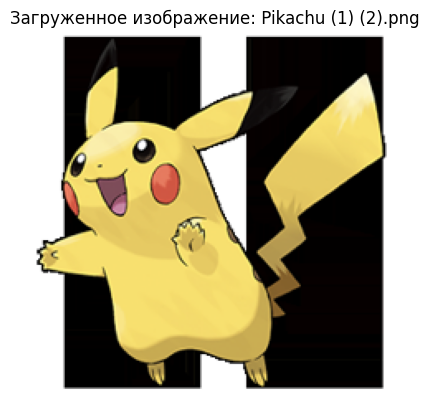

In [ ]:
# Загрузка изображения с компьютера
uploaded = files.upload()  # Нам нужно загрузить файл, поскольку по ссылке он не открывается
file_name = list(uploaded.keys())[0]  # Получаем имя загруженного файла

# Открытие изображения
img = Image.open(file_name)

# Удаление альфа-канала (если он есть) , а у нас он у нас есть потому что при обычной загрузке изображения пикачу он не распознается.
 # (наше изображение, загруженное из PNG-файла, имеет 4 канала (RGBA), а модель MobileNetV2 ожидает 3 канала (RGB). поэтому нужно удалить альфа-канал
if img.mode == 'RGBA':
    img = img.convert('RGB')  # Преобразуем в RGB, удаляя альфа-канал

# Измененяем размера изображения до 224x224 (требование MobileNetV2)
img = img.resize((224, 224))

# Преобразуем изображение в массив numpy
img_array = np.array(img)

# Добавляем размерности батча и предобработку
img_array = preprocess_input(img_array[np.newaxis, ...])

# Проверяем формы изображения
print(f"Форма изображения после предобработки: {img_array.shape}")  # Должно быть (1, 224, 224, 3)

# используем уже обученную и созданную до меня сверточную нейронную сеть, которая сможет распознать изображение) # Загружаем модель MobileNetV2
model = MobileNetV2(weights='imagenet')

# Получаем предсказания
predictions = model.predict(img_array)
decoded_predictions = decode_predictions(predictions, top=1)[0]
print(f"Распознанный объект: {decoded_predictions[0][1]} с уверенностью {decoded_predictions[0][2]:.2f}")

# Отображение загруженного изображения
plt.imshow(img)
plt.title(f"Загруженное изображение: {file_name}")
plt.axis('off')
plt.show()

In [ ]:
#Изображение отличается от первоначального, доступного по ссылке в файле задания, но это произошло в следствие предыдущих преобразования (удаления альфа канала)
#Проверяем распознавание нашего Пикачу
predictions = model.predict(img_array)
decoded_predictions = decode_predictions(predictions, top=1)[0]
print(f"Распознанный объект: {decoded_predictions[0][1]} с уверенностью {decoded_predictions[0][2]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Распознанный объект: mortarboard с уверенностью 0.16


In [ ]:
#получается что наша модель не распознала пикачу, попробуем обучить свою модель с помощью датасета c изображениями покемонов

In [ ]:
import kagglehub #возьмем отсюда датасет с изображениями различных покемонов

# Скачаем последнюю версию
path = kagglehub.dataset_download("lantian773030/pokemonclassification")

print("Path to dataset files:", path) # узнаем путь к данным

Path to dataset files: /root/.cache/kagglehub/datasets/lantian773030/pokemonclassification/versions/1


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Путь к данным
train_dir = '/content/pokemon_dataset/PokemonData'

# Подготовка данных
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Нормализация пикселей
    validation_split=0.2  # Разделение на обучение и валидацию
)

# Создание генераторов данных
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128), # Уменьшим размер изображений, чтобы ускорить обучение модели
    batch_size=64, # увеличим размер батча с 32 до 64, чтобы модель быстрее обучалась
    class_mode='categorical', #Многоклассовая классификация
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128), # Уменьшим размер изображений, чтобы ускорить обучение модели
    batch_size=64, # увеличим размер батча с 32 до 64, чтобы модель быстрее обучалась
    class_mode='categorical',
    subset='validation'
)

# Преобразуем DirectoryIterator в tf.data.Dataset
def generator_to_dataset(generator):
    dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_signature=(
            tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32),  # Форма изображений
            tf.TensorSpec(shape=(None, generator.num_classes), dtype=tf.float32)  # Форма меток
        )
    )
    return dataset

train_dataset = generator_to_dataset(train_generator)
validation_dataset = generator_to_dataset(validation_generator)

# Применяем кэширование и предварительную выборку, чтобы ускорить обучение модели
train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 5511 images belonging to 150 classes.
Found 1309 images belonging to 150 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers

# Создаем свою модель CNN
model = Sequential([ # Создаем последовательную модель, где слои добавляются один за другим.
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),  # Размер изображений 128x128, Сверточный слой с 32 фильтрами размером 3x3, функция активации relu.
    MaxPooling2D((2, 2)), # Добавляем слой подвыборки с окном 2x2, который уменьшает размерность данных вдвое.
    Conv2D(64, (3, 3), activation='relu'), # Второй сверточный слой с 64 фильтрами размером 3x3.
    MaxPooling2D((2, 2)), #Второй слой подвыборки с окном 2x2.
    Conv2D(128, (3, 3), activation='relu'), #Третий сверточный слой с 128 фильтрами размером 3x3.
    MaxPooling2D((2, 2)), #Третий слой подвыборки с окном 2x2.
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  #Полносвязный слой с 128 нейронами.#L2-регуляризация с коэффициентом 0.01 для предотвращения переобучения.
    Dropout(0.5), #Слой Dropout с вероятностью 0.5 (50% нейронов будут отключены случайным образом во время обучения).
    Dense(train_generator.num_classes, activation='softmax')  # Выходной слой будет с количеством нейронов, равным количеству классов.Функция активации softmax для многоклассовой классификации.
])

# Компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Обучение модели
history = model.fit(
    train_generator,
    epochs=10, #возьмем 10 эпох
    validation_data=validation_generator
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 226s 3s/step - accuracy: 0.0065 - loss: 5.8197 - val_accuracy: 0.0130 - val_loss: 4.9601
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 243s 3s/step - accuracy: 0.0117 - loss: 4.9505 - val_accuracy: 0.0321 - val_loss: 4.7620
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 225s 3s/step - accuracy: 0.0330 - loss: 4.7698 - val_accuracy: 0.0848 - val_loss: 4.3917
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step - accuracy: 0.0783 - loss: 4.4040 - val_accuracy: 0.1658 - val_loss: 3.8781
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 221s 3s/step - accuracy: 0.1077 - loss: 4.0663 - val_accuracy: 0.1933 - val_loss: 3.6618
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 222s 3s/step - accuracy: 0.1342 - loss: 3.8251 - val_accuracy: 0.2368 - val_loss: 3.4482
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 221s 3s/step - accuracy: 0.1608 - loss: 3.7073 - val_accuracy: 0.2811 - val_loss: 3.2242
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.1966 - loss: 3.5092 - val_accuracy: 0.2918 - v

In [ ]:
# Сохранение модели
model.save('pokemon_classifier_model.h5')  # Сохраняем модель в файл
print("Модель сохранена в файл 'pokemon_classifier_model.h5'")

Модель сохранена в файл 'pokemon_classifier_model.h5'


In [ ]:
# В итоге получилось, что точность достаточно не высокая, ее можно будет увеличить в дальнейшем, с помощью увеличения количества эпох, но пока что этого делать не будем, чтобы сэкономить время

Saving Pikachu (1).png to Pikachu (1) (8).png


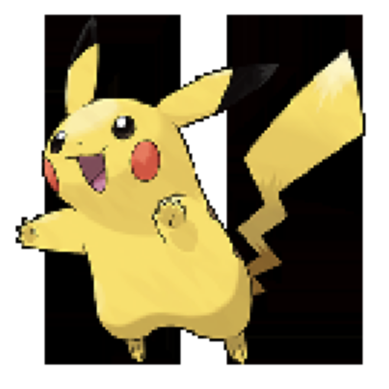

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Распознанный класс: Pikachu
Уверенность: 19.12%


In [ ]:
# Шаг 4: Теперь загружаем изображение нашего Пикачу
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Загрузка изображения
uploaded = files.upload()
for file_name in uploaded.keys():
    img_path = file_name
    img = image.load_img(img_path, target_size=(128, 128))  # Будем использовать тот же размер, что и во время обучения
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Преобразование изображения в массив
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Добавим нормализацию

    # Предсказание
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)

    # Получение имени класса
    class_names = list(train_generator.class_indices.keys())
    predicted_label = class_names[predicted_class[0]]

    print(f"Распознанный класс: {predicted_label}")
    print(f"Уверенность: {np.max(predictions) * 100:.2f}%")

In [ ]:
#Класс изображения определен верно.

Saving Pikachu (1).png to Pikachu (1) (15).png


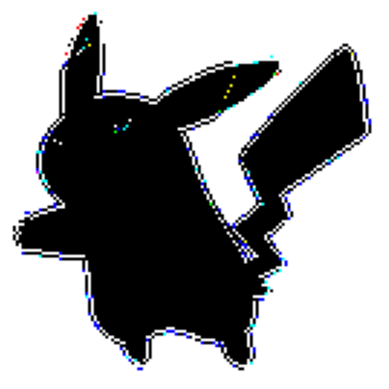

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


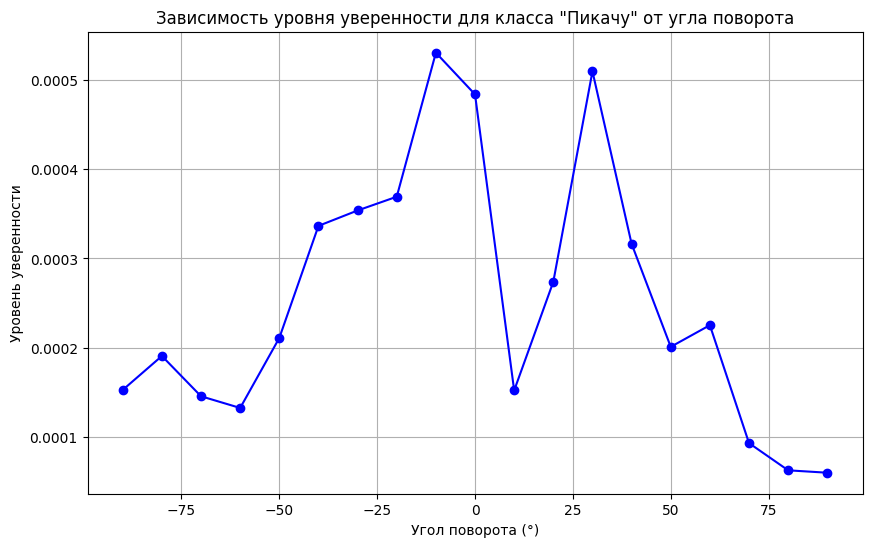

In [ ]:
# Продолжаем работу с моделью
model = load_model('pokemon_classifier_model.h5')  # Указываем путь к нашей модели

# Функция для загрузки изображения и замены недостающих пикселей черным цветом
def load_and_preprocess_image(img_path, target_size=(128, 128)):
    img = Image.open(img_path)
    img = img.resize(target_size, Image.Resampling.LANCZOS)  # Используем LANCZOS вместо ANTIALIAS (потому что с ANTIALIAS не работает, почему-то)
    img_array = image.img_to_array(img)

    # Замена недостающих пикселей черным цветом
    if img_array.shape[2] < 3:  # Так как наше изображение изначально не RGB
        img_array = np.concatenate([img_array] * 3, axis=-1)  # То, преобразуем в RGB
    img_array = img_array[:, :, :3]  # Обрезаем до 3 каналов (RGB)

    # Нормализация изображения
    img_array = preprocess_input(img_array)
    return img_array

# Функция для поворота изображения
def rotate_image(img_array, angle):
    img = Image.fromarray(img_array.astype('uint8'))
    img = img.rotate(angle)
    return image.img_to_array(img)

# Загрузка изображения
uploaded = files.upload()
for file_name in uploaded.keys():
    img_path = file_name
    img_array = load_and_preprocess_image(img_path)  # Загружаем и предобрабатываем изображение
    img = Image.fromarray(img_array.astype('uint8'))  # Преобразуем обратно в изображение для отображения
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Уровень уверенности для класса "Пикачу"
pikachu_index = list(train_generator.class_indices.keys()).index('Pikachu')  # Индекс класса "Пикачу"

# Зависимость уровня уверенности от угла поворота
angles = range(-90, 91, 10)  # Углы от -90° до 90° с шагом 10°
confidences = []

for angle in angles:
    # Поворачиваем изображение
    rotated_img_array = rotate_image(img_array, angle)
    rotated_img_array = preprocess_input(rotated_img_array)

    # Предсказание модели
    predictions = model.predict(np.expand_dims(rotated_img_array, axis=0))
    confidences.append(predictions[0][pikachu_index])  # Уровень уверенности для "Пикачу"

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(angles, confidences, marker='o', linestyle='-', color='b')
plt.title('Зависимость уровня уверенности для класса "Пикачу" от угла поворота')
plt.xlabel('Угол поворота (°)')
plt.ylabel('Уровень уверенности')
plt.grid(True)
plt.show()

Saving Pikachu (1).png to Pikachu (1) (16).png


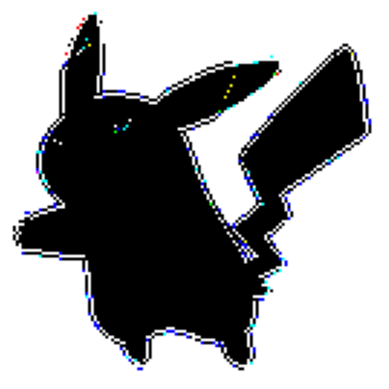

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


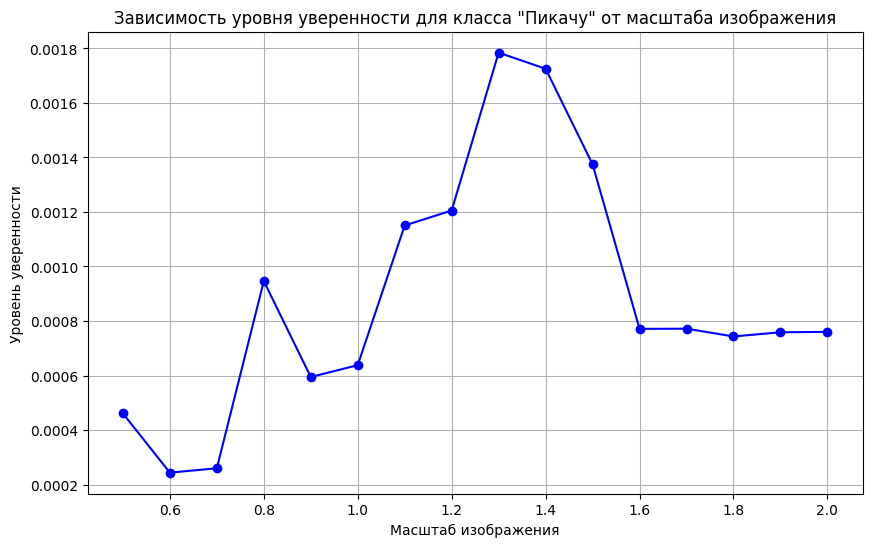

In [ ]:
# Обращаемся к нашей модели
model = load_model('pokemon_classifier_model.h5')  # Указываем путь

# Функция для загрузки изображения и замены недостающих пикселей черным цветом
def load_and_preprocess_image(img_path, target_size=(128, 128)):
    img = Image.open(img_path)
    img = img.resize(target_size, Image.Resampling.LANCZOS)  # Изменение размера изображения
    img_array = image.img_to_array(img)

    # Замена недостающих пикселей черным цветом
    if img_array.shape[2] < 3:
        img_array = np.concatenate([img_array] * 3, axis=-1)  # Преобразуем в RGB
    img_array = img_array[:, :, :3]

    # Нормализация изображения
    img_array = preprocess_input(img_array)
    return img_array

# Функция для масштабирования изображения по горизонтальной оси
def scale_image(img_array, scale):
    img = Image.fromarray(img_array.astype('uint8'))
    width, height = img.size
    new_width = int(width * scale)
    img = img.resize((new_width, height), Image.Resampling.LANCZOS)
    return image.img_to_array(img)

# Загрузка изображения
uploaded = files.upload()
for file_name in uploaded.keys():
    img_path = file_name
    img_array = load_and_preprocess_image(img_path)  # Загружаем и предобрабатываем изображение
    img = Image.fromarray(img_array.astype('uint8'))  # Преобразуем обратно в изображение для отображения
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Уровень уверенности для класса "Пикачу"
pikachu_index = list(train_generator.class_indices.keys()).index('Pikachu')  # Индекс класса "Пикачу"

# Зависимость уровня уверенности от масштаба изображения
scales = np.arange(0.5, 2.1, 0.1)  # Масштабы от 0.5 до 2 с шагом 0.1
confidences = []

for scale in scales:
    # Масштабируем изображение
    scaled_img_array = scale_image(img_array, scale)

    # Если изображение стало больше, обрезаем его до исходного размера
    if scaled_img_array.shape[1] > 128:
        scaled_img_array = scaled_img_array[:, :128, :]
    # Если изображение стало меньше, дополняем черными пикселями
    elif scaled_img_array.shape[1] < 128:
        pad_width = 128 - scaled_img_array.shape[1]
        scaled_img_array = np.pad(scaled_img_array, ((0, 0), (0, pad_width), (0, 0)), mode='constant')

    # Нормализация изображения
    scaled_img_array = preprocess_input(scaled_img_array)

    # Предсказание модели
    predictions = model.predict(np.expand_dims(scaled_img_array, axis=0))
    confidences.append(predictions[0][pikachu_index])  # Уровень уверенности для "Пикачу"

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(scales, confidences, marker='o', linestyle='-', color='b')
plt.title('Зависимость уровня уверенности для класса "Пикачу" от масштаба изображения')
plt.xlabel('Масштаб изображения')
plt.ylabel('Уровень уверенности')
plt.grid(True)
plt.show()



Saving Pikachu (1).png to Pikachu (1) (17).png


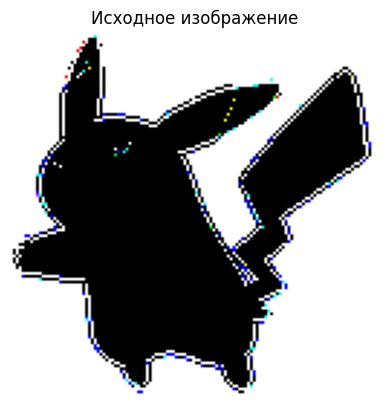

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


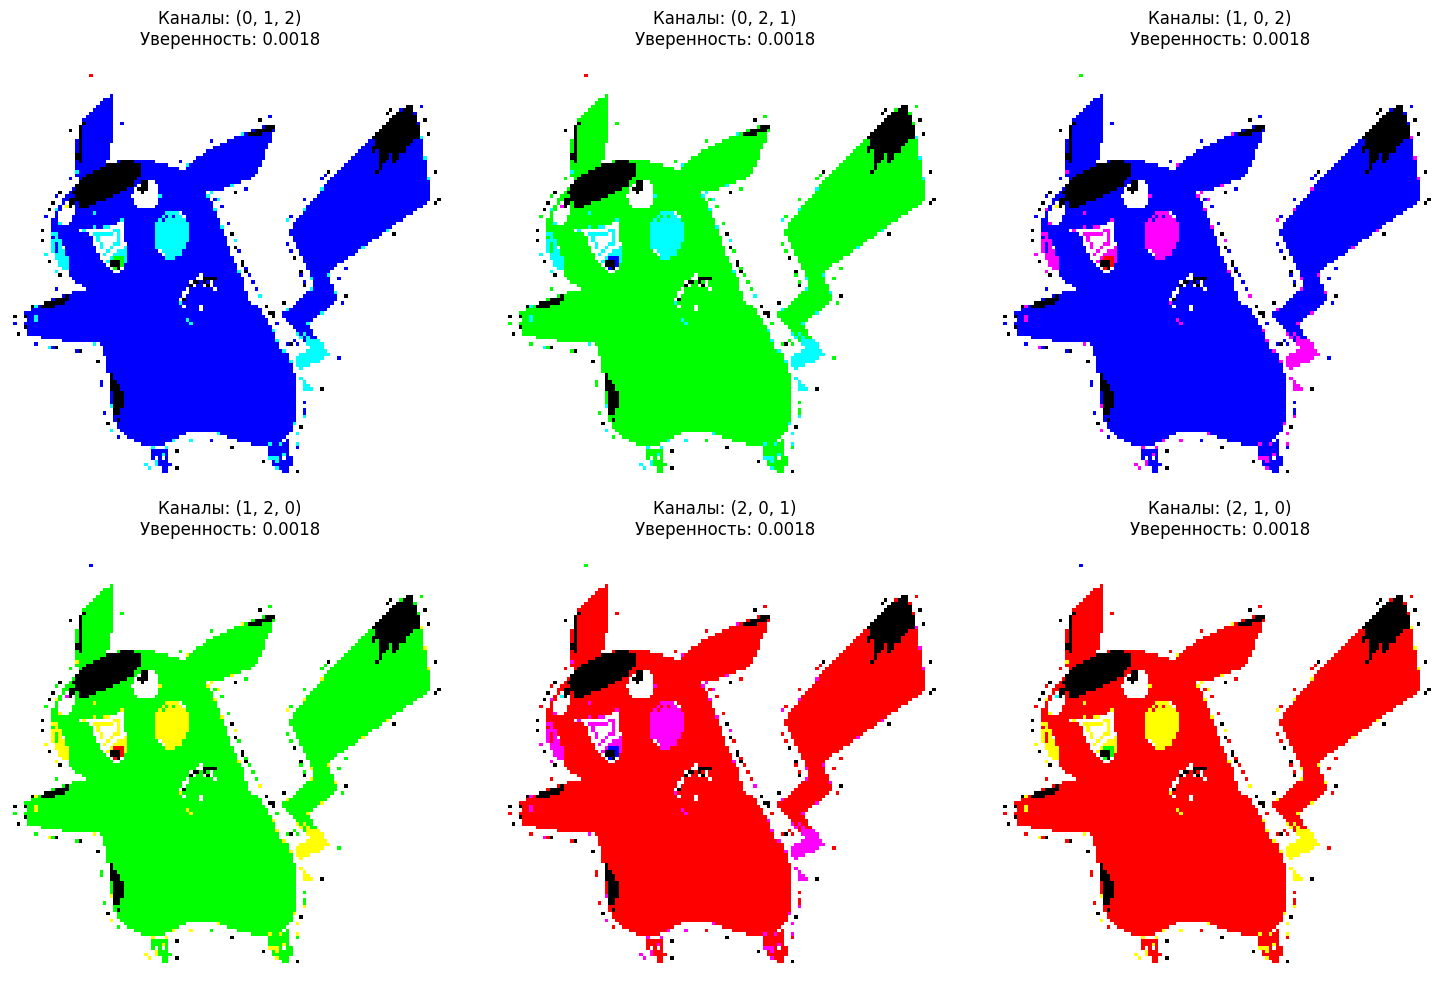

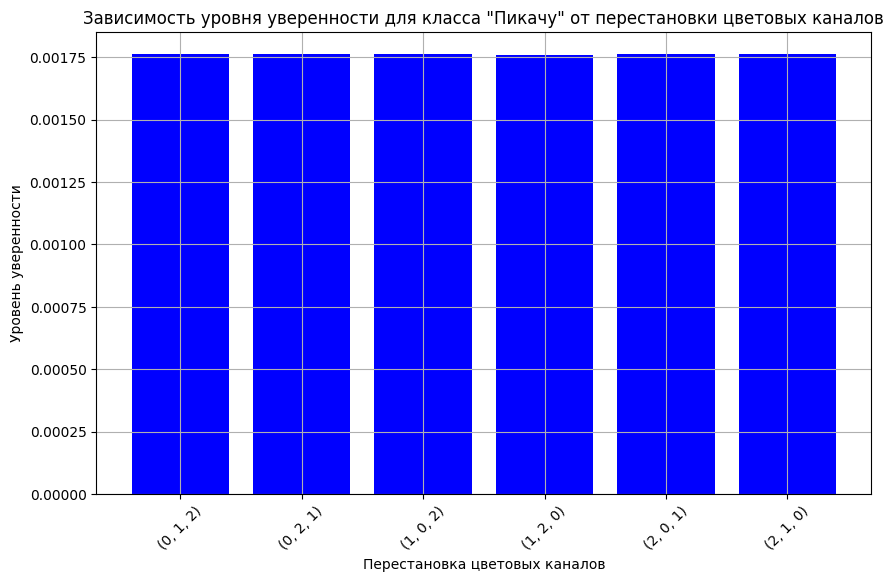

In [ ]:
from itertools import permutations

# Обращаемся к нашей модели
model = load_model('pokemon_classifier_model.h5')

# Функция для загрузки изображения и замены недостающих пикселей черным цветом
def load_and_preprocess_image(img_path, target_size=(128, 128)):
    img = Image.open(img_path)
    img = img.resize(target_size, Image.Resampling.LANCZOS)  # Изменяем размер изображения
    img_array = image.img_to_array(img)

    # Заменяем недостающие пиксели черным цветом
    if img_array.shape[2] < 3:
        img_array = np.concatenate([img_array] * 3, axis=-1)  # Преобразуем в RGB
    img_array = img_array[:, :, :3]

    # Нормализация изображения
    img_array = preprocess_input(img_array)
    return img_array

# Функция для перестановки цветовых каналов
def permute_channels(img_array, channel_order):
    return img_array[:, :, channel_order]

# Загрузка изображения
uploaded = files.upload()
for file_name in uploaded.keys():
    img_path = file_name
    img_array = load_and_preprocess_image(img_path)  # Загружаем и предобрабатываем изображение
    img = Image.fromarray(img_array.astype('uint8'))  # Преобразуем обратно в изображение для отображения
    plt.imshow(img)
    plt.axis('off')
    plt.title('Исходное изображение')
    plt.show()

# Уровень уверенности для класса "Пикачу"
pikachu_index = list(train_generator.class_indices.keys()).index('Pikachu')  # Индекс класса "Пикачу"

# Все возможные перестановки цветовых каналов (без повторений)
channel_orders = list(permutations([0, 1, 2]))

# Зависимость уровня уверенности от перестановки цветовых каналов
confidences = []
permuted_images = []

for order in channel_orders:
    # Переставляем цветовые каналы
    permuted_img_array = permute_channels(img_array, order)
    permuted_images.append(permuted_img_array)

    # Нормализация изображения
    permuted_img_array = preprocess_input(permuted_img_array)

    # Предсказание модели
    predictions = model.predict(np.expand_dims(permuted_img_array, axis=0))
    confidences.append(predictions[0][pikachu_index])  # Уровень уверенности для "Пикачу"

# Отображаем все измененные изображения с подписью результатов
plt.figure(figsize=(15, 10))
for i, (order, confidence) in enumerate(zip(channel_orders, confidences)):
    plt.subplot(2, 3, i + 1)
    plt.imshow(permuted_images[i].astype('uint8'))
    plt.title(f'Каналы: {order}\nУверенность: {confidence:.4f}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Строим график
plt.figure(figsize=(10, 6))
plt.bar(range(len(confidences)), confidences, color='blue')
plt.xticks(range(len(confidences)), [str(order) for order in channel_orders], rotation=45)
plt.title('Зависимость уровня уверенности для класса "Пикачу" от перестановки цветовых каналов')
plt.xlabel('Перестановка цветовых каналов')
plt.ylabel('Уровень уверенности')
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


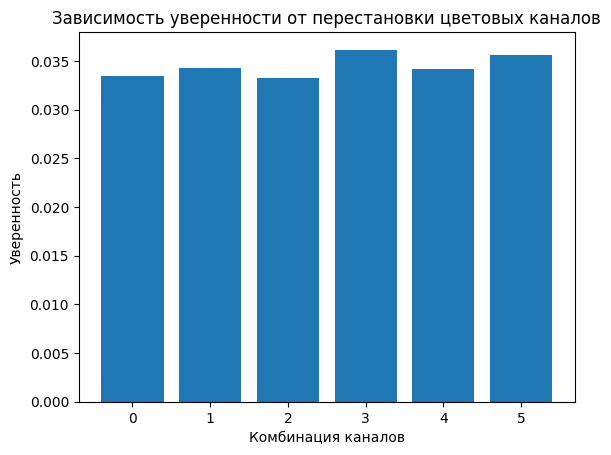

In [117]:
from itertools import permutations # Поменяем немного график, чтобы лучше были видны различия

channels = list(permutations([0, 1, 2]))
confidences = []

for channel_order in channels:
    swapped_img = np.array(img)[:, :, list(channel_order)]
    swapped_array = preprocess_input(swapped_img[np.newaxis, ...])
    predictions = model.predict(swapped_array)
    confidences.append(predictions[0][np.argmax(predictions)])

plt.bar(range(len(confidences)), confidences)
plt.title('Зависимость уверенности от перестановки цветовых каналов')
plt.xlabel('Комбинация каналов')
plt.ylabel('Уверенность')
plt.savefig('channel_confidence.png')
plt.show()

In [ ]:
#Выводы:

#Модель работает плохо, с низкой точностью, но это можно решить с помощью увеличения эпох.
#По экспериментам:
#1) Моя сверточная нейронная сеть работает с низкой уверенностью при повороте угла изображения.
#При этом довольно большой разброс наблюдается при изменении угла наклона изображения в уровне уверенности в классе "Пикачу", оптимально отклонение угла должно быть в пределах +-25 градусов.
#2) Наиболее высокий уровень уверенности наблюдается при масштабировании от 1.0 до 1.6 , в случае если изображение близится к 0 по масштабу (например 0.6), то уровень уверенности минимален.
#3) Удивительно, но уровень уверенности стабилен при изменении цветовых каналов, конечно, он стабильно мал. Но видимо CNN очень хорошо работают с изменением цветовых каналов и распознают изображение по другим факторам, где очередность цветов не главный фактор.

In [ ]:
# Архивируем результаты
import shutil
import os

# Создаем папку для сохранения результатов
output_dir = "experiment_results"
os.makedirs(output_dir, exist_ok=True)

shutil.make_archive(output_dir, 'zip', output_dir)
print(f"Все результаты сохранены в архив '{output_dir}.zip'")


Все результаты сохранены в архив 'experiment_results.zip'
